# Cheap Chicago Living

## Final Project for Applied Data Science Capstone Course

In [1]:
# Import the necessary libraries
from geopy.geocoders import Nominatim
import folium
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup # For scraping websites
# requests for fetching html of website
from requests import get
import requests

In [2]:
# Create a geolocator using Nominatim of OpenStreetMap
geolocator = Nominatim(timeout=10, user_agent = "sje.Capstone-Project")

## I chose to base my data collection and analysis around the CTA metro (known as 'the el')
#### I found data about the metro stops on the City of Chicago Data Portal

In [3]:
# Read the CSV using the City of Chicago data
stations = pd.read_csv("https://data.cityofchicago.org/api/views/8pix-ypme/rows.csv?accessType=DOWNLOAD")
stations.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
1,30161,E,18th (Loop-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
3,30023,S,35th/Archer (Midway-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
4,30214,S,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"


### Since my test case (a young person looking for a cheap apartment with lots of bars near the Blue Line) I selected only blue line stations to work with

In [4]:
blue_line = stations[ stations['BLUE'] == True ]
blue_line = pd.DataFrame(blue_line)
blue_line.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
33,30002,W,Austin (Forest Pk-bound),Austin,Austin (Blue Line),40010,False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"
34,30001,E,Austin (O'Hare-bound),Austin,Austin (Blue Line),40010,False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"
37,30013,S,Belmont (O'Hare Branch) (Forest Pk-bound),Belmont,Belmont (Blue Line),40060,False,False,True,False,False,False,False,False,False,False,"(41.938132, -87.712359)"
38,30012,N,Belmont (O'Hare Branch) (O'Hare-bound),Belmont,Belmont (Blue Line),40060,False,False,True,False,False,False,False,False,False,False,"(41.938132, -87.712359)"
61,30188,W,Cicero (Forest Pk-bound),Cicero,Cicero (Blue Line),40970,False,False,True,False,False,False,False,False,False,False,"(41.871574, -87.745154)"


#### Each stop is listed twice, so I remove duplicates

In [5]:
blue_line.drop_duplicates(subset ="Location", inplace = True)
blue_line.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
33,30002,W,Austin (Forest Pk-bound),Austin,Austin (Blue Line),40010,False,False,True,False,False,False,False,False,False,False,"(41.870851, -87.776812)"
37,30013,S,Belmont (O'Hare Branch) (Forest Pk-bound),Belmont,Belmont (Blue Line),40060,False,False,True,False,False,False,False,False,False,False,"(41.938132, -87.712359)"
61,30188,W,Cicero (Forest Pk-bound),Cicero,Cicero (Blue Line),40970,False,False,True,False,False,False,False,False,False,False,"(41.871574, -87.745154)"
67,30374,S,Clark/Lake (Forest Pk-bound),Clark/Lake,"Clark/Lake (Blue, Brown, Green, Orange, Purple...",40380,True,False,True,False,False,False,False,False,False,False,"(41.885737, -87.630886)"
69,30085,W,Clinton (Forest Pk-bound),Clinton,Clinton (Blue Line),40430,False,False,True,False,False,False,False,False,False,False,"(41.875539, -87.640984)"


In [6]:
# Spliting location data into two columns to extract the longitude and latitude
blue_line['Latitude'], blue_line['Longitude'] = blue_line['Location'].str.split(' ', 1).str

<ipython-input-6-81229e559806>:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  blue_line['Latitude'], blue_line['Longitude'] = blue_line['Location'].str.split(' ', 1).str


In [7]:
# Drop all the extra columns
blue_line.drop(['DIRECTION_ID', 'STATION_NAME', 'MAP_ID', 'STOP_NAME', 'ADA', 'RED', 'BLUE', 'G', 'BRN', 'P', 'Pexp', 'Y', 'Pnk', 'O'], axis = 1, inplace=True)
# Rename some columns
blue_line['STATION_DESCRIPTIVE_NAME'] = blue_line['STATION_DESCRIPTIVE_NAME'].str.replace('(Blue Line)', '', regex=False)
blue_line.rename(columns={'STATION_DESCRIPTIVE_NAME': 'Station'}, inplace=True)
blue_line.head()

,STOP_ID,Station,Location,Latitude,Longitude
33,30002,Austin,"(41.870851, -87.776812)","(41.870851,",-87.776812)
37,30013,Belmont,"(41.938132, -87.712359)","(41.938132,",-87.712359)
61,30188,Cicero,"(41.871574, -87.745154)","(41.871574,",-87.745154)
67,30374,"Clark/Lake (Blue, Brown, Green, Orange, Purple...","(41.885737, -87.630886)","(41.885737,",-87.630886)
69,30085,Clinton,"(41.875539, -87.640984)","(41.875539,",-87.640984)


In [8]:
blue_line.set_index("STOP_ID", inplace=True)
blue_line.head()

,Station,Location,Latitude,Longitude
STOP_ID,,,,
30002,Austin,"(41.870851, -87.776812)","(41.870851,",-87.776812)
30013,Belmont,"(41.938132, -87.712359)","(41.938132,",-87.712359)
30188,Cicero,"(41.871574, -87.745154)","(41.871574,",-87.745154)
30374,"Clark/Lake (Blue, Brown, Green, Orange, Purple...","(41.885737, -87.630886)","(41.885737,",-87.630886)
30085,Clinton,"(41.875539, -87.640984)","(41.875539,",-87.640984)


In [9]:
# Rename Clark/Lake
blue_line.at[30374,'Station'] = 'Clark/Lake'

#### Some station names contain other station names, which will make searching later very difficult. I rename them with abbreviations instead.

In [10]:
blue_line['Station'] = blue_line["Station"].str.replace('(Blue Line - O\'Hare Branch)', '(OH Branch)', regex=False)
blue_line['Station'] = blue_line["Station"].str.replace('(Blue Line - Forest Park Branch)', '(FB Branch)', regex=False)

In [11]:
blue_line.tail()

,Station,Location,Latitude,Longitude
STOP_ID,,,,
30111,California,"(41.921939, -87.69689)","(41.921939,",-87.69689)
30271,Chicago,"(41.896075, -87.655214)","(41.896075,",-87.655214)
30130,Western (OH Branch),"(41.916157, -87.687364)","(41.916157,",-87.687364)
30042,Western (FB Branch),"(41.875478, -87.688436)","(41.875478,",-87.688436)
30240,Addison,"(41.94738, -87.71906)","(41.94738,",-87.71906)


In [12]:
# Extract location data and save as floats
blue_line['Longitude'] = blue_line["Longitude"].str.replace(')', '', regex=False)
blue_line['Latitude'] = blue_line["Latitude"].str.replace('(', '', regex=False)
blue_line['Latitude'] = blue_line["Latitude"].str.replace(',', '', regex=False)
blue_line[["Longitude"]] = blue_line[["Longitude"]].astype("float")
blue_line[["Latitude"]] = blue_line[["Latitude"]].astype("float")
blue_line.head()

,Station,Location,Latitude,Longitude
STOP_ID,,,,
30002,Austin,"(41.870851, -87.776812)",41.870851,-87.776812
30013,Belmont,"(41.938132, -87.712359)",41.938132,-87.712359
30188,Cicero,"(41.871574, -87.745154)",41.871574,-87.745154
30374,Clark/Lake,"(41.885737, -87.630886)",41.885737,-87.630886
30085,Clinton,"(41.875539, -87.640984)",41.875539,-87.640984


### Add zipcodes to dataframe for use later when scraping Craigslist

In [26]:
# This function strips the parenthesis from the 'Location' column and returns a zipcode string
def getzip (location_info):
    
    zipcode = geolocator.geocode(location_info[1:-1], addressdetails=True).raw['address']['postcode']
    return zipcode[0:5]

In [27]:
blue_line.iloc[0].Location

'(41.870851, -87.776812)'

In [28]:
getzip(blue_line.iloc[0].Location)

60130


'60130'

In [29]:
blue_line['Zipcode'] = blue_line['Location'].apply(getzip)
blue_line.head()

60130
60659
60644
60696
60606
60631
606476
60642
60130
60661
60656
60130
60607
60641
60604
60630
60607
60605
60647
60641
60603
60130
60607
60607
60688-9998
60018
60607
60602
60625
60642
60647
60607
60618


,Station,Location,Latitude,Longitude,Zipcode
STOP_ID,,,,,
30002,Austin,"(41.870851, -87.776812)",41.870851,-87.776812,60130
30013,Belmont,"(41.938132, -87.712359)",41.938132,-87.712359,60659
30188,Cicero,"(41.871574, -87.745154)",41.871574,-87.745154,60644
30374,Clark/Lake,"(41.885737, -87.630886)",41.885737,-87.630886,60696
30085,Clinton,"(41.875539, -87.640984)",41.875539,-87.640984,60606


In [31]:
# Let's get the basic location data for Chicago, just to get started
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="sje_capstone-project")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


## Here is a map of the Chicago Blue Line stops, with a circle of 600m around each stop. This represents the area all further searching and analysis will take place

In [32]:
# create map of Chciago using latitude and longitude values
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, station in zip(blue_line['Latitude'], blue_line['Longitude'], blue_line['Station']):
    label = station
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)
    folium.Circle([lat, lng], radius=600, color='red', fill=False).add_to(map_chicago)
  
    
map_chicago


# CL Scraping Sections

In [33]:
from time import sleep
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
from geopy import distance

In [34]:
# Create a list of zipcodes to scrape
blue_line.reset_index(drop=True, inplace=True)
blue_line.head()

,Station,Location,Latitude,Longitude,Zipcode
0,Austin,"(41.870851, -87.776812)",41.870851,-87.776812,60130
1,Belmont,"(41.938132, -87.712359)",41.938132,-87.712359,60659
2,Cicero,"(41.871574, -87.745154)",41.871574,-87.745154,60644
3,Clark/Lake,"(41.885737, -87.630886)",41.885737,-87.630886,60696
4,Clinton,"(41.875539, -87.640984)",41.875539,-87.640984,60606


In [35]:
ziplist = blue_line['Zipcode']
ziplist = list(dict.fromkeys(ziplist))
print(ziplist)
print(str(len(ziplist)) + " unique zipcodes")

['60130', '60659', '60644', '60696', '60606', '60631', '60647', '60642', '60661', '60656', '60607', '60641', '60604', '60630', '60605', '60603', '60688', '60018', '60602', '60625', '60618']
21 unique zipcodes


### Craigslist scraping involved creating long URLs to specify your search parameters

In [36]:
# This function concats all of the search paramters into a long url
def get_cl_url (zipcode, distance, page, min_bed, max_bed):
    cl_url =("https://chicago.craigslist.org/search/apa?"
                   + "&search_distance="
                   + distance
                   + "&postal="
                   + zipcode
                   + "&min_bedrooms="
                   + min_bed
                   + "&max_bedrooms="
                   + max_bed
                   + "&s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&availabilityMode=0")
    return cl_url

Because the listing page doesn't have location data (lat and long), 
I wrote a function to visit that link, and pull the data for that listing.

In [37]:
# This function pulls the location data by scraping the page on a URL
def get_loc_from_listing (url):
  #get the latitude and longitude from a URL listing
  listingHtml = get(url)
  listSoup = BeautifulSoup(listingHtml.text, 'html.parser')
  location = listSoup.find_all(class_= 'viewposting')
  loc = []
  if location[0] is None:
      loc.append('null')
      loc.append('null')

  else:
      loc.append(float(location[0]['data-latitude']))
      loc.append(float(location[0]['data-longitude']))
  return loc

Here is where the data is scraped from Craigslist. I found that if the entire city of Chicago was scraped, many apartment listings were missing from the data. A workaround is to use each zipcode in the blue_line dataset as a search parameter, and then just remove duplicates later.

In [ ]:
# Create empty arrays for storing data
post_title_texts = []
post_hoods = []
post_links = []
post_prices = []
longitudes = []
latitudes = []
post_zipcodes = []

for zipcode in ziplist:
    
    #get the first page of the chicago housing listings in this zipcode
    response = get(get_cl_url(zipcode,'2','0','0','1')) # 0 or 1 bedrooms 2 mi from zipcode

    html_soup = BeautifulSoup(response.text, 'html.parser')

    #get the macro-container for the housing posts
    posts = html_soup.find_all('li', class_= 'result-row')


    #find the total number of posts to find the limit of the pagination
    results_num = html_soup.find('div', class_= 'search-legend')
    results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

    #each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
    pages = np.arange(0, results_total+1, 120)

    iterations = 0


    for page in pages:

        #get request
        response = get(get_cl_url(zipcode,'2', page,'0','1')) #Searches for one bedrooms or studios

        sleep(randint(1,5))

        #throw warning for status codes that are not 200
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        #define the html text
        page_html = BeautifulSoup(response.text, 'html.parser')

        #define the posts
        posts = html_soup.find_all('li', class_= 'result-row')

        #extract data item-wise
        for post in posts:

            if post.find('span', class_ = 'result-hood') is not None:

                #neighborhoods
                post_hood = post.find('span', class_= 'result-hood').text
                post_hoods.append(post_hood)

                #title text
                post_title = post.find('a', class_='result-title hdrlnk')
                post_title_text = post_title.text
                post_title_texts.append(post_title_text)

                #post link
                post_link = post_title['href']
                post_links.append(post_link)

                # Location Data
                bothloc = get_loc_from_listing(post_link)
                latitudes.append(bothloc[0])
                longitudes.append(bothloc[1])

                #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
                post_price = post.a.text.strip().replace("$", "")
                post_prices.append(post_price)
                
                # Records the zipcode it was searched by
                post_zipcodes.append(zipcode)


        iterations += 1
        print("Page " + str(iterations) + " of zipcode "+ zipcode + " scraped successfully!")


print("\n")

print("Scrape complete!")

In [ ]:
#write dataframe to file so I don't have to scrape again
chi_apts.to_csv("scraped_data.csv")  

In [39]:
# Saves the scraped data to a dataframe
chi_apts = pd.DataFrame({'neighborhood': post_hoods,
                       'post title': post_title_texts,
                        'URL': post_links,
                       'price': post_prices,
                        'longitude': longitudes,
                        'latitude': latitudes})
chi_apts.head(10)

NameError: name 'post_hoods' is not defined

In [41]:
# Use this if the data has already been scraped and saved
chi_apts = pd.read_csv("scraped_data.csv")
chi_apts.head()

,Unnamed: 0,neighborhood,post title,URL,price,longitude,latitude
0,0,(Forest Park),"BRIGHT 1 BED, SS Appliances with Balcony - MET...",https://chicago.craigslist.org/nch/apa/d/fores...,995.0,-87.8106,41.8744
1,1,(Forest Park),Studio ($690) and 1 Bedroom ($810/$850) Apartm...,https://chicago.craigslist.org/nwc/apa/d/studi...,NaN,-87.8106,41.8744
2,2,(FOREST PARK),GIANT BALCONY & HEATED GARAGE 1 BDRM APT.,https://chicago.craigslist.org/wcl/apa/d/giant...,1100.0,-87.8106,41.8744
3,3,(Forest Park),SEMI-MODERN ONE BEDROOMS FROM $1005-1015 - 227,https://chicago.craigslist.org/wcl/apa/d/fores...,1005.0,-87.8106,41.8744
4,4,(Forest Park),"FOREST PARK / OAK PARK 1 Bedroom, Balcony, 601...",https://chicago.craigslist.org/nch/apa/d/fores...,985.0,-87.8106,41.8744


In [42]:
chi_apts.shape

(8813, 7)

### Craigslist data cleaning section

In [43]:
# Drops any apartments missing price data
chi_apts.drop( chi_apts[ chi_apts['price'] == '' ].index , inplace=True)
chi_apts.dropna(subset=['price'], inplace=True)
# Convert prices to int
chi_apts['price'] = chi_apts['price'].apply(lambda x: int(x))
# Drop any apartments less than 300 (often spam)
chi_apts.drop( chi_apts[ chi_apts['price'] <500 ].index , inplace=True)
# Drop any apartments more than 5000 (often spam or mis-listings)
chi_apts.drop( chi_apts[ chi_apts['price'] >5000 ].index , inplace=True)
# Remove duplicates with same URL - these are relistings
chi_apts = chi_apts.drop_duplicates(subset='URL')
# Remove duplicates with same post titles and price - these are most likely relistings
chi_apts = chi_apts.drop_duplicates(subset=['post title', 'price'])
chi_apts.sort_values(['price'], inplace=True)

chi_apts.reset_index(drop=True, inplace=True)


/Users/samanthagoodman/.local/share/virtualenvs/Coursera_Capstone-w3K9iyP0/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [45]:
chi_apts.shape

(808, 7)

In [46]:
# Add nearby stations column for each apartment listing
chi_apts['Nearby Stations'] = 'None'

In [47]:
# For each stop in the blue line listing
for index, row in blue_line.iterrows(): 
    # Stores this stops location data
    station_lat = row['Latitude']
    station_long = row['Longitude']
    station_name = row['Station']
    # For each listing in the apartments datframe
    for index, apt_row in chi_apts.iterrows():
        # If it is less than 600 meters from the stop, add the stop name to the column
        if distance.distance((station_lat, station_long), (apt_row.latitude, apt_row.longitude)).m < 600:
            if chi_apts.at[index,'Nearby Stations'] == 'None':
                chi_apts.at[index,'Nearby Stations'] = station_name
            else:
                chi_apts.at[index,'Nearby Stations'] += (", " + station_name)

In [48]:
# Saves the nearby apartments to a new dataframe
nearby_apts = chi_apts.drop( chi_apts[ chi_apts['Nearby Stations'] == 'None' ].index)

In [49]:
# Rates the price of the apartment, based on three categories
nearby_apts['Rent'] = pd.cut(nearby_apts['price'], bins=3, labels=['low', 'med', 'high'])

In [50]:
nearby_apts['Rent'].value_counts()

med     204
low     115
high     16
Name: Rent, dtype: int64

In [51]:
# Builds empty dataframe for storing all data on each train stop (our goal!)
columns = ['Train Stop', 'Avg Rent', 'Num Apts', 'Cheap', 'Med', 'Luxury', 'Bars']
stop_data = pd.DataFrame(columns=columns)

# Stores the names of each stop in a row
stop_data['Train Stop'] = blue_line['Station']
stop_data['Longitude'] = blue_line['Longitude']
stop_data['Latitude'] = blue_line['Latitude']

In [52]:
stop_data.head()

,Train Stop,Avg Rent,Num Apts,Cheap,Med,Luxury,Bars,Longitude,Latitude
0,Austin,NaN,NaN,NaN,NaN,NaN,NaN,-87.776812,41.870851
1,Belmont,NaN,NaN,NaN,NaN,NaN,NaN,-87.712359,41.938132
2,Cicero,NaN,NaN,NaN,NaN,NaN,NaN,-87.745154,41.871574
3,Clark/Lake,NaN,NaN,NaN,NaN,NaN,NaN,-87.630886,41.885737
4,Clinton,NaN,NaN,NaN,NaN,NaN,NaN,-87.640984,41.875539


### Now that we have an empty dataframe for all 33 stops of the Blue Line, we will fill it with data from the nearby_apts

In [53]:
# For each stop in stop_data
for index, row in stop_data.iterrows():
    # store the stop name as a string
    station_name = row['Train Stop']
    # Count the total number of apartments nearby
    stop_data.at[index, 'Num Apts'] = int(nearby_apts[nearby_apts['Nearby Stations'].str.contains(station_name)].count().price)
    # If there are apartments nearby, calculate the average rent
    if(stop_data.at[index, 'Num Apts'] !=0):
        stop_data.at[index, 'Avg Rent'] = int(nearby_apts[nearby_apts['Nearby Stations'].str.contains(station_name)].mean().price)
    else:
        stop_data.at[index, 'Avg Rent'] = None
    # Count the number of low, med, high rent apartments near this stop
    stop_data.at[index,'Cheap'] = nearby_apts.loc[(nearby_apts['Nearby Stations'].str.contains(station_name)) & (nearby_apts['Rent']=='low')].count().price
    stop_data.at[index,'Med'] = nearby_apts.loc[(nearby_apts['Nearby Stations'].str.contains(station_name)) & (nearby_apts['Rent']=='med')].count().price
    stop_data.at[index,'Luxury'] = nearby_apts.loc[(nearby_apts['Nearby Stations'].str.contains(station_name)) & (nearby_apts['Rent']=='high')].count().price

/Users/samanthagoodman/.local/share/virtualenvs/Coursera_Capstone-w3K9iyP0/lib/python3.8/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [54]:
stop_data.sort_values(['Avg Rent'], inplace=True)
stop_data.reset_index(drop=True, inplace=True)
# Drops all train stops that currently have no apartments listed nearby
stop_data = stop_data.drop( stop_data[ stop_data['Num Apts'] == 0 ].index)

In [56]:
stop_data.head()

,Train Stop,Avg Rent,Num Apts,Cheap,Med,Luxury,Bars,Longitude,Latitude
0,Austin,950,6,6,0,0,NaN,-87.776812,41.870851
1,Forest Park,1006,8,8,0,0,NaN,-87.817318,41.874257
2,Jefferson Park,1062,4,4,0,0,NaN,-87.760892,41.970634
3,Logan Square,1322,31,30,1,0,NaN,-87.708541,41.929728
4,Oak Park,1330,9,9,0,0,NaN,-87.791602,41.872108


### Here is a map with all nearby apartments added

In [57]:
# create map of Chicago using latitude and longitude values
map_damen = folium.Map(location=[latitude, longitude], zoom_start=15)

# add station markers to map
for lat, lng, station in zip(blue_line['Latitude'], blue_line['Longitude'], blue_line['Station']):
    label = station
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_damen)
    folium.Circle([lat, lng], radius=600, color='red', fill=False).add_to(map_damen)

# add apartment markers to map
for lat, lng, price in zip(nearby_apts['latitude'], nearby_apts['longitude'], ('$' + nearby_apts['price'].astype('str'))):
    label = price
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=1,
        parse_html=False).add_to(map_damen)  
    
map_damen

# Foursquare Section
## The next goal is get all bars withing 600m of a train stop, so we can compare train stops

In [58]:
CLIENT_ID = 'V3B13NWETEWPBCDTZN0ZV0DWICYSVMSNIXJ5YVPFM4ILS51M' # my Foursquare ID
CLIENT_SECRET = '2JSJLEWXWFCVC1LEEGYK5TXYPTQMNRZDEFZ1EX0TVHXXWRBK' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: V3B13NWETEWPBCDTZN0ZV0DWICYSVMSNIXJ5YVPFM4ILS51M
CLIENT_SECRET:2JSJLEWXWFCVC1LEEGYK5TXYPTQMNRZDEFZ1EX0TVHXXWRBK


In [59]:
stop_data.head()

,Train Stop,Avg Rent,Num Apts,Cheap,Med,Luxury,Bars,Longitude,Latitude
0,Austin,950,6,6,0,0,NaN,-87.776812,41.870851
1,Forest Park,1006,8,8,0,0,NaN,-87.817318,41.874257
2,Jefferson Park,1062,4,4,0,0,NaN,-87.760892,41.970634
3,Logan Square,1322,31,30,1,0,NaN,-87.708541,41.929728
4,Oak Park,1330,9,9,0,0,NaN,-87.791602,41.872108


In [60]:
# Lets explore the Damen stop
stop_data.loc[3, 'Longitude']

-87.708541

In [61]:
stop_latitude = stop_data.loc[12, 'Latitude'] # neighborhood latitude value
stop_longitude = stop_data.loc[12, 'Longitude'] # neighborhood longitude value

stop_name = stop_data.loc[12, 'Train Stop'] # stop name

print('Latitude and longitude values of {} are {}, {}.'.format(stop_name, 
                                                               stop_latitude, 
                                                               stop_longitude))

Latitude and longitude values of Damen  are 41.909744, -87.677437.


In [62]:
# Defines a function that creates a foursquare URL to use the API
def get_foursquare_url (lat, long, radius, limit, section):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&section={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, VERSION, radius, limit, section)
    return url

In [63]:
url = get_foursquare_url(stop_latitude, stop_longitude, 600, 200, 'drinks')

In [64]:
results = requests.get(url).json()

In [65]:
results_dam = requests.get(get_foursquare_url(stop_latitude, stop_longitude, 600, 100, 'drinks')).json()

In [66]:
results_log = requests.get(get_foursquare_url(stop_data.loc[3, 'Latitude'], stop_data.loc[3, 'Longitude'], 600, 200, 'drinks')).json()

In [67]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [68]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Piece Brewery and Pizzeria,Pizza Place,41.910403,-87.676145
1,Big Star,Taco Place,41.909229,-87.677279
2,The Violet Hour,Speakeasy,41.909048,-87.677631
3,The Robey Lounge,Lounge,41.910593,-87.678017
4,Tapster,Beer Bar,41.910395,-87.678516


In [69]:
nearby_venues.rename(columns={'lat': 'latitude', 'lng': 'longitude'}, inplace=True)

In [70]:
nearby_venues.head(20)

,name,categories,latitude,longitude
0,Piece Brewery and Pizzeria,Pizza Place,41.910403,-87.676145
1,Big Star,Taco Place,41.909229,-87.677279
2,The Violet Hour,Speakeasy,41.909048,-87.677631
3,The Robey Lounge,Lounge,41.910593,-87.678017
4,Tapster,Beer Bar,41.910395,-87.678516
5,Links Taproom,Bar,41.909894,-87.676488
6,SubT Lounge,Bar,41.910528,-87.677956
7,Up & Up,Cocktail Bar,41.910636,-87.678200
8,Dorian’s,Speakeasy,41.910368,-87.676684
9,Subterranean,Rock Club,41.910497,-87.677964


In [71]:
nearby_venues['isBar'] = nearby_venues['categories'].str.contains('Bar|Speakeasy|Lounge|Nightclub|Pub|Gastropub|Brewery')

In [72]:
nearby_venues.head(40)

,name,categories,latitude,longitude,isBar
0,Piece Brewery and Pizzeria,Pizza Place,41.910403,-87.676145,False
1,Big Star,Taco Place,41.909229,-87.677279,False
2,The Violet Hour,Speakeasy,41.909048,-87.677631,True
3,The Robey Lounge,Lounge,41.910593,-87.678017,True
4,Tapster,Beer Bar,41.910395,-87.678516,True
5,Links Taproom,Bar,41.909894,-87.676488,True
6,SubT Lounge,Bar,41.910528,-87.677956,True
7,Up & Up,Cocktail Bar,41.910636,-87.678200,True
8,Dorian’s,Speakeasy,41.910368,-87.676684,True
9,Subterranean,Rock Club,41.910497,-87.677964,False


In [73]:
bars = nearby_venues[ nearby_venues['isBar'] == True ]

In [74]:
bars.count().isBar

27

In [75]:
def get_area_bars (lat, long, radius):
    url = get_foursquare_url(lat, long, radius, 200, 'drinks')
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    
    nearby_venues = pd.json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    
    # rename columns
    nearby_venues.rename(columns={'lat': 'latitude', 'lng': 'longitude'}, inplace=True)
    
    # See if it's a bar based on category name
    nearby_venues['isBar'] = nearby_venues['categories'].str.contains('Bar|Speakeasy|Lounge|Nightclub|Pub|Gastropub|Brewery')
    
    bars = nearby_venues[ nearby_venues['isBar'] == True ]
    
    return bars

In [76]:
wi_bars = get_area_bars (stop_latitude, stop_longitude, 600)

In [77]:
wi_bars.count().isBar

27

In [78]:
stop_data.head()

,Train Stop,Avg Rent,Num Apts,Cheap,Med,Luxury,Bars,Longitude,Latitude
0,Austin,950,6,6,0,0,NaN,-87.776812,41.870851
1,Forest Park,1006,8,8,0,0,NaN,-87.817318,41.874257
2,Jefferson Park,1062,4,4,0,0,NaN,-87.760892,41.970634
3,Logan Square,1322,31,30,1,0,NaN,-87.708541,41.929728
4,Oak Park,1330,9,9,0,0,NaN,-87.791602,41.872108


In [79]:
op_bars = get_area_bars(stop_data.iloc[4].Latitude, stop_data.iloc[4].Longitude, 600)

In [80]:
op_bars.head()

,name,categories,latitude,longitude,isBar
0,Avenue Ale House and Rooftop Cafe,Bar,41.873336,-87.794238,True
1,Hideaway Night Club,Bar,41.873622,-87.788281,True
2,Elvis' Showcase,Speakeasy,41.875685,-87.795041,True


In [81]:
# For each stop in stop_data
for index, row in stop_data.iterrows(): 
    # Stores this stops location data
    station_lat = row['Latitude']
    station_long = row['Longitude']
    station_name = row['Train Stop']
    sleep(randint(1,5))
    nearby_bars = get_area_bars(station_lat, station_long, 600)
    num_bars = nearby_bars.count().isBar
    stop_data.at[index, 'Bars'] = num_bars

In [186]:
stop_data.head()

,Train Stop,Avg Rent,Num Apts,Cheap,Med,Luxury,Bars,Longitude,Latitude
0,Logan Square,1322,31,30,1,0,19,-87.708541,41.929728
1,LaSalle,1882,101,24,74,3,23,-87.631722,41.875568
2,Oak Park,1330,9,9,0,0,3,-87.791602,41.872108
3,Washington,2015,54,8,34,12,53,-87.629440,41.883164
4,Forest Park,1006,8,8,0,0,4,-87.817318,41.874257


In [83]:
stop_data.sort_values(by=['Cheap','Avg Rent','Bars'], inplace=True, ascending=False)
stop_data.head()

,Train Stop,Avg Rent,Num Apts,Cheap,Med,Luxury,Bars,Longitude,Latitude
3,Logan Square,1322,31,30,1,0,19,-87.708541,41.929728
10,LaSalle,1882,101,24,74,3,23,-87.631722,41.875568
4,Oak Park,1330,9,9,0,0,3,-87.791602,41.872108
16,Washington,2015,54,8,34,12,53,-87.629440,41.883164
1,Forest Park,1006,8,8,0,0,4,-87.817318,41.874257


In [ ]:
stop_data.head(30)

### Data Analysis Section

In [90]:
# we are using the inline backend
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

In [91]:
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.3


In [219]:
stop_data.head()

,Train Stop,Avg Rent,Num Apts,Cheap,Med,Luxury,Bars,Longitude,Latitude
0,Logan Square,1322,31,30,1,0,19,-87.708541,41.929728
1,LaSalle,1882,101,24,74,3,23,-87.631722,41.875568
2,Oak Park,1330,9,9,0,0,3,-87.791602,41.872108
3,Washington,2015,54,8,34,12,53,-87.629440,41.883164
4,Forest Park,1006,8,8,0,0,4,-87.817318,41.874257


In [112]:
# Reset index based on sorting
stop_data.reset_index(drop=True, inplace=True)
stop_data.head()

,Train Stop,Avg Rent,Num Apts,Cheap,Med,Luxury,Bars,Longitude,Latitude
0,Logan Square,1322,31,30,1,0,19,-87.708541,41.929728
1,LaSalle,1882,101,24,74,3,23,-87.631722,41.875568
2,Oak Park,1330,9,9,0,0,3,-87.791602,41.872108
3,Washington,2015,54,8,34,12,53,-87.629440,41.883164
4,Forest Park,1006,8,8,0,0,4,-87.817318,41.874257


In [113]:
top_stops = stop_data.iloc[0:10]

In [114]:
top_stops = top_stops[['Train Stop', 'Cheap', 'Bars']]
top_stops.rename(columns={'Cheap': 'Cheap Apts'}, inplace=True)


In [115]:
top_stops.set_index("Train Stop", inplace=True)
top_stops.head()

,Cheap Apts,Bars
Train Stop,,
Logan Square,30,19
LaSalle,24,23
Oak Park,9,3
Washington,8,53
Forest Park,8,4


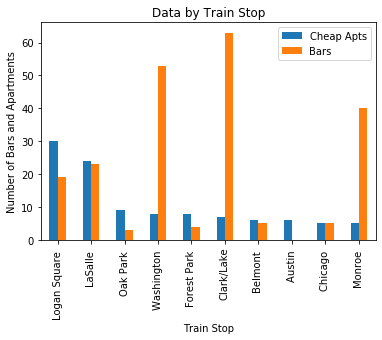

In [116]:
top_stops.plot(kind='bar')

plt.title('Data by Train Stop')
plt.ylabel('Number of Bars and Apartments')
plt.xlabel('Train Stop')


plt.show() 

### As we can see from the graph, there are many train stops with lots of bars (notably downtown). However, without a cheap aparment to live in, one will not have any money to drink with.

Lets take a look at the top two train stops with the most cheap apartments and bars: Logan Square and LaSalle

In [187]:
logan = nearby_apts[nearby_apts['Nearby Stations'].str.contains('Logan Square')]

In [190]:
lasalle = nearby_apts[nearby_apts['Nearby Stations'].str.contains('LaSalle')]

In [170]:
logan = logan[['price']]
lasalle = lasalle[['price']]

In [188]:
logan.shape

(31, 9)

In [193]:
lasalle.head()

,Unnamed: 0,neighborhood,post title,URL,price,longitude,latitude,Nearby Stations,Rent
326,5558,(Chicago - South Loop),Natural light STUDIO! Full amenity building! I...,https://chicago.craigslist.org/chc/apa/d/chica...,1450,-87.627700,41.871300,LaSalle,low
351,5530,(Chicago - South Loop),Steps to Redline and Grant Park! South Loop Jr...,https://chicago.craigslist.org/chc/apa/d/chica...,1510,-87.627700,41.871300,LaSalle,low
355,5531,(Chicago - South Loop),"S.Loop Jr.1Bed Hwd Flrs, Floor to Ceiling Wind...",https://chicago.craigslist.org/chc/apa/d/chica...,1525,-87.627700,41.871300,LaSalle,low
357,4460,(Chicago - South Loop),"Newer Construction, Studio, WD in unit, hardwo...",https://chicago.craigslist.org/chc/apa/d/chica...,1531,-87.633219,41.874258,"Jackson , LaSalle",low
358,4540,(South Loop),"Studio - 24 hour fitness, FREE Starbuck's Coff...",https://chicago.craigslist.org/chc/apa/d/chica...,1534,-87.630596,41.871011,LaSalle,low


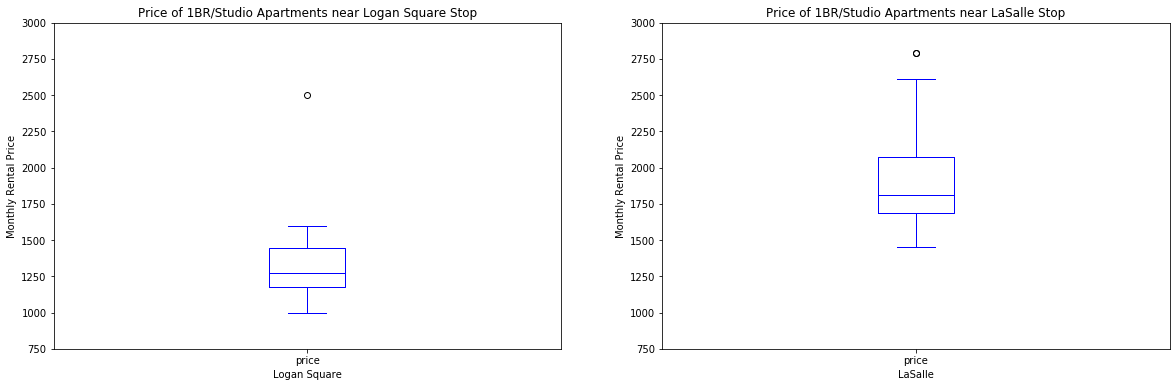

In [194]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
logan['price'].plot(kind='box', color='blue', figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Price of 1BR/Studio Apartments near Logan Square Stop')
ax0.set_xlabel('Logan Square')
ax0.set_ylabel('Monthly Rental Price')
ax0.set_ylim([750,3000])

# Subplot 2: Line plot
lasalle['price'].plot(kind='box', color='blue', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title('Price of 1BR/Studio Apartments near LaSalle Stop')
ax1.set_xlabel('LaSalle')
ax1.set_ylabel('Monthly Rental Price')
ax1.set_ylim([750,3000])

plt.show()

Although the two train stops (Logan Square and LaSalle) have similar number of "cheap" apartments (30 and 24, respectively)
the price of apartments within 600m of the train varies a lot as you can see from the above box plots.

Logan Square has a much cheaper apartments, on the whole. This fact is likely to correlate with the price of drinks in the vincinity.
If an area has expensive apartments, the bars are likely to be expensive as well. If our apartment-seeker is looking for inexpensive bars, Logan Square
is a better choice.

## Maps of the top 2 neighborhoods

In [213]:
logan_cheap = logan.loc[logan['Rent'] == 'low']
logan_med = logan.loc[logan['Rent'] == 'med']
logan_lux = logan.loc[logan['Rent'] == 'high']

lasalle_cheap = lasalle.loc[lasalle['Rent'] == 'low']
lasalle_med = lasalle.loc[lasalle['Rent'] == 'med']
lasalle_lux = lasalle.loc[lasalle['Rent'] == 'high']

In [ ]:
logan_bars = get_area_bars (stop_data.iloc[0].Latitude, stop_data.iloc[0].Longitude, 600)

In [200]:
lasalle_bars = get_area_bars (stop_data.iloc[1].Latitude, stop_data.iloc[1].Longitude, 600)

In [203]:
lasalle_bars.head()

,name,categories,latitude,longitude,isBar
0,First Draft,Sports Bar,41.873259,-87.630563,True
1,Kasey's Tavern,Pub,41.873317,-87.629284,True
3,The Marq,Bar,41.879010,-87.629732,True
4,Sky-Ride Cocktail Lounge,Dive Bar,41.876851,-87.630879,True
7,Brando's Speakeasy,Speakeasy,41.877175,-87.629143,True


In [218]:
# create map of Near Logan Square using latitude and longitude values
map_logan = folium.Map(location=[stop_data.iloc[0].Latitude, stop_data.iloc[0].Longitude], zoom_start=16)

# add station markers to map
for lat, lng, station in zip(blue_line['Latitude'], blue_line['Longitude'], blue_line['Station']):
    label = station
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_logan)
                                 
# Add a red circle around Logan Square Stop
folium.Circle([stop_data.iloc[0].Latitude, stop_data.iloc[0].Longitude], radius=600, color='red', fill=False).add_to(map_logan)

# add cheap apartment markers to map
for lat, lng, price in zip(logan_cheap['latitude'], logan_cheap['longitude'], ('$' + logan_cheap['price'].astype('str'))):
    label = price
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=1,
        parse_html=False).add_to(map_logan)  

# add med apartment markers to map
for lat, lng, price in zip(logan_med['latitude'], logan_med['longitude'], ('$' + logan_med['price'].astype('str'))):
    label = price
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=1,
        parse_html=False).add_to(map_logan)  
                                 
                                 
# add bar markers to map
for lat, lng, name in zip(logan_bars['latitude'], logan_bars['longitude'], logan_bars['name']):
    label = name
    label = folium.Popup(label, parse_html=True)   
    folium.Marker(
        location=[lat, lng],
        popup=label,
        icon=folium.Icon(color='blue', icon='glass')
    ).add_to(map_logan)
map_logan

In [220]:
# create map of Near lasalle Square using latitude and longitude values
map_lasalle = folium.Map(location=[stop_data.iloc[1].Latitude, stop_data.iloc[1].Longitude], zoom_start=16)

# add station markers to map
for lat, lng, station in zip(blue_line['Latitude'], blue_line['Longitude'], blue_line['Station']):
    label = station
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lasalle)
                                 
# Add a red circle around lasalle Square Stop
folium.Circle([stop_data.iloc[1].Latitude, stop_data.iloc[1].Longitude], radius=600, color='red', fill=False).add_to(map_lasalle)

# add cheap apartment markers to map
for lat, lng, price in zip(lasalle_cheap['latitude'], lasalle_cheap['longitude'], ('$' + lasalle_cheap['price'].astype('str'))):
    label = price
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=1,
        parse_html=False).add_to(map_lasalle)  

# add med apartment markers to map
for lat, lng, price in zip(lasalle_med['latitude'], lasalle_med['longitude'], ('$' + lasalle_med['price'].astype('str'))):
    label = price
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=1,
        parse_html=False).add_to(map_lasalle)  
    
# add lux apartment markers to map
for lat, lng, price in zip(lasalle_lux['latitude'], lasalle_lux['longitude'], ('$' + lasalle_lux['price'].astype('str'))):
    label = price
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1,
        parse_html=False).add_to(map_lasalle)                                   
                                 
# add bar markers to map
for lat, lng, name in zip(lasalle_bars['latitude'], lasalle_bars['longitude'], lasalle_bars['name']):
    label = name
    label = folium.Popup(label, parse_html=True)   
    folium.Marker(
        location=[lat, lng],
        popup=label,
        icon=folium.Icon(color='blue', icon='glass')
    ).add_to(map_lasalle)
map_lasalle